# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from etl import safe_literal_eval, dtype_checker, movies_df, credits_parquet

2384
11796
Memory used: 263.46 MB
Memory used: 263.46 MB
Memory used: 261.52 MB
Memory used: 261.52 MB


[NbConvertApp] Converting notebook etl.ipynb to script
[NbConvertApp] Writing 25688 bytes to etl.py


### Let's recover the fields vote_count and voten average from the CSV movie file.

In [2]:
movies_csv = pd.read_csv("data/movies_dataset.csv")

C:\Users\jdieg\AppData\Local\Temp\ipykernel_17292\3445815435.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_csv = pd.read_csv("data/movies_dataset.csv")


In [3]:
movies_df = movies_df.merge(movies_csv[["id","vote_count", "vote_average"]], on="id", how="left")

### Missing Data

In [4]:
movies_df.isna().sum()

collection_id           40944
budget                      0
id                          0
original_language          11
production_countries        0
release_date                0
revenue                     0
runtime                   246
spoken_languages            0
title                       0
release_year                0
return_on_investment        0
vote_count                  0
vote_average                0
dtype: int64

Having a look at original language field

In [5]:
movies_df[movies_df["original_language"].isna()].head()

,collection_id,budget,id,original_language,production_countries,release_date,revenue,runtime,spoken_languages,title,release_year,return_on_investment,vote_count,vote_average
19595,NaN,0.0,283101,None,"[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...",2004-10-11,0.0,95.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Shadowing the Third Man,2004,0.0,0.0,0.0
21621,NaN,0.0,103902,None,"[{'iso_3166_1': 'AU', 'name': 'Australia'}]",2007-08-04,0.0,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Unfinished Sky,2007,0.0,8.0,6.4
22849,NaN,0.0,359195,None,"[{'iso_3166_1': 'US', 'name': 'United States o...",1960-03-31,0.0,69.0,"[{'iso_639_1': 'en', 'name': 'English'}]",13 Fighting Men,1960,0.0,0.0,0.0
32155,NaN,0.0,147050,None,"[{'iso_3166_1': 'US', 'name': 'United States o...",1929-10-31,0.0,8.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Lambchops,1929,0.0,2.0,6.5
37410,NaN,0.0,257095,None,"[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'}]",1950-01-26,0.0,87.0,"[{'iso_639_1': 'cs', 'name': 'Český'}]",Prince Bayaya,1950,0.0,1.0,5.0


And those rows with null values in field original_language also has missing values on other field sudh as vote_count, vote_average, etc.. having 3 features missing is a significant for our EDa.. so that the more suitable approach is drop them

In [6]:
movies_df.dropna(subset=["original_language"], inplace=True)

### runtime feature missing values

In [7]:
movies_df[movies_df["runtime"].isna()].head()

,collection_id,budget,id,original_language,production_countries,release_date,revenue,runtime,spoken_languages,title,release_year,return_on_investment,vote_count,vote_average
634,NaN,0.0,287305,de,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1996-03-21,0.0,NaN,"[{'iso_639_1': 'Unknown', 'name': 'Unknown'}]",Peanuts – Die Bank zahlt alles,1996,0.0,1.0,4.0
635,NaN,0.0,339428,de,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1996-03-14,65335.0,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Happy Weekend,1996,0.0,0.0,0.0
644,NaN,0.0,278978,de,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1996-02-29,0.0,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Und keiner weint mir nach,1996,0.0,0.0,0.0
801,NaN,0.0,282919,de,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1996-06-20,0.0,NaN,"[{'iso_639_1': 'Unknown', 'name': 'Unknown'}]",Diebinnen,1996,0.0,1.0,4.0
863,NaN,0.0,253632,fr,"[{'iso_3166_1': 'Unknown', 'name': 'Unknown'}]",1988-10-08,0.0,NaN,"[{'iso_639_1': 'Unknown', 'name': 'Unknown'}]",Baton Rouge,1988,0.0,0.0,0.0


Some features like revenue, budget, in consecuents roi (shor for return_on_investment), and some vote_count values in zero. Since this is few missing data, the more suitable approach is dropping those rows.

In [8]:
movies_df.dropna(subset=["runtime"], inplace=True)

In [9]:
movies_df.isna().sum()

collection_id           40694
budget                      0
id                          0
original_language           0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
title                       0
release_year                0
return_on_investment        0
vote_count                  0
vote_average                0
dtype: int64

### collection_id feature
collection_id features is an exception here since this refers to more information about certain movies that are related to other ones (there's another dataset from etl that can be imported to merge on this id). A more appropriate feature would be adding a new feture that only indicates if it bellongs to a collection.

In [10]:
movies_df["bellongs_to_collection"] = ~movies_df["collection_id"].isnull()

In [11]:
movies_df.isnull().sum()

collection_id             40694
budget                        0
id                            0
original_language             0
production_countries          0
release_date                  0
revenue                       0
runtime                       0
spoken_languages              0
title                         0
release_year                  0
return_on_investment          0
vote_count                    0
vote_average                  0
bellongs_to_collection        0
dtype: int64

By now, we will allow the collection_id feature for the EDA, and may be drop it latter when will be time for training the recomendation model

# Hipothesys

I would like to know how predominant the language english is in the movies. Parhaps thet would be an outlier. And there are two things about languages: the original language wich the movie was produced and the languages availability for each movie. Let's have a look at this proportions

In [12]:
movies_df[["original_language", "spoken_languages"]]

,original_language,spoken_languages
0,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
1,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso..."
2,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
3,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
4,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
...,...,...
45433,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
45434,tl,"[{'iso_639_1': 'tl', 'name': ''}]"
45435,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
45436,en,"[{'iso_639_1': 'Unknown', 'name': 'Unknown'}]"


In [13]:
movies_df["spoken_languages"]

0                 [{'iso_639_1': 'en', 'name': 'English'}]
1        [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
2                 [{'iso_639_1': 'en', 'name': 'English'}]
3                 [{'iso_639_1': 'en', 'name': 'English'}]
4                 [{'iso_639_1': 'en', 'name': 'English'}]
                               ...                        
45433             [{'iso_639_1': 'en', 'name': 'English'}]
45434                    [{'iso_639_1': 'tl', 'name': ''}]
45435             [{'iso_639_1': 'en', 'name': 'English'}]
45436        [{'iso_639_1': 'Unknown', 'name': 'Unknown'}]
45437             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, Length: 45181, dtype: object

This is odd, can you see in the visualization of the cell above the language "tl"? this iso 639 1 code does not have a name.. Let's take a look at those rows by creating a booleant mask for "tl"

In [14]:
tl_language_mask = movies_df["spoken_languages"].apply(lambda languages: 
                                                       # This only evauates this: Is "tl" in this generator
                                                       # The generator can be readen as this: for each disctionary object language in this list of languages,
                                                       # throughs the iso_639_1 key in the generator
                                                       "tl" in (language["iso_639_1"] for language in languages))

In [15]:
movies_df[tl_language_mask].tail()

,collection_id,budget,id,original_language,production_countries,release_date,revenue,runtime,spoken_languages,title,release_year,return_on_investment,vote_count,vote_average,bellongs_to_collection
42284,NaN,0.0,418378,tl,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2016-10-27,0.0,120.0,"[{'iso_639_1': 'tl', 'name': ''}]",Die Beautiful,2016,0.0,2.0,7.5,False
42977,NaN,0.0,392790,tl,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2016-11-09,0.0,110.0,"[{'iso_639_1': 'tl', 'name': ''}]",Ma' Rosa,2016,0.0,2.0,6.0,False
44176,NaN,0.0,74829,tl,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",1983-06-10,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",The Killing of Satan,1983,0.0,1.0,5.0,False
44574,NaN,0.0,302104,tl,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2014-11-09,0.0,110.0,"[{'iso_639_1': 'tl', 'name': ''}]",That Thing Called Tadhana,2014,0.0,4.0,6.5,False
45434,NaN,0.0,111109,tl,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Century of Birthing,2011,0.0,3.0,9.0,False


and it seems that "tl" shows up as a original_language for any Philipine movie... remind this, in the cell above, we are filtering against spoken_language feature.

And after researching at google, it seems "tl" iso 3166 1 code is related to the language Tagalog. A language spoken by a quarter of the population of the Philpines. Click (or tap) on [here](https://en.wikipedia.org/wiki/Tagalog_language) for further information. Let's fill this data.

In [16]:
(   # The movies dataframe filtered only spoken languages that contains the iso_639_1 code "tl", 
    # then grab the spoken language field only
    movies_df.loc[tl_language_mask, "spoken_languages"]
    # Then apply this lambda expression
    .apply(lambda 
           # In the records wich contains a list of dictionaries
           languages: 
           # Evaluate this list comprehention, where for each language in languages, build the dictionary {"iso_639_1": "XXX", "name": "XXX"} 
           # Having the conditionals, in the dictionary constructor, "name" key is going to be "Tagolog" if the "iso_639_1" code evaluates True the value "tl"
           # else, just write the original value.
           [{"iso_639_1": language["iso_639_1"], "name" : "Tagolog" if language["iso_639_1"] == "tl" else language["name"]} 
            for language in languages]
            )
         )

297      [{'iso_639_1': 'tl', 'name': 'Tagolog'}, {'iso...
772               [{'iso_639_1': 'tl', 'name': 'Tagolog'}]
4940     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
6690     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
8518     [{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639...
8968     [{'iso_639_1': 'cn', 'name': '广州话 / 廣州話'}, {'i...
9551     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
9720     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
9924     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
13649    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
14222             [{'iso_639_1': 'tl', 'name': 'Tagolog'}]
16046    [{'iso_639_1': 'cn', 'name': '广州话 / 廣州話'}, {'i...
16275             [{'iso_639_1': 'tl', 'name': 'Tagolog'}]
17043             [{'iso_639_1': 'tl', 'name': 'Tagolog'}]
18517             [{'iso_639_1': 'tl', 'name': 'Tagolog'}]
18933             [{'iso_639_1': 'tl', 'name': 'Tagolog'}]
19332             [{'iso_639_1': 'tl', 'name': 'Tagolog'

In [17]:
movies_df.loc[tl_language_mask,"spoken_languages"] =  (movies_df.loc[tl_language_mask, "spoken_languages"]
                                    .apply(lambda languages: [
                                        {"iso_639_1": language["iso_639_1"], "name" : "Tagolog" if language["iso_639_1"] == "tl" else language["name"]} 
                                        for language in languages]))

In [18]:
# Lets check the result..
movies_df[tl_language_mask].head()

,collection_id,budget,id,original_language,production_countries,release_date,revenue,runtime,spoken_languages,title,release_year,return_on_investment,vote_count,vote_average,bellongs_to_collection
297,NaN,0.0,30304,en,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",1995-05-05,0.0,94.0,"[{'iso_639_1': 'tl', 'name': 'Tagolog'}, {'iso...",Picture Bride,1995,0.000000,5.0,7.4,False
772,NaN,0.0,183955,en,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",1994-09-09,0.0,100.0,"[{'iso_639_1': 'tl', 'name': 'Tagolog'}]",Midnight Dancers,1994,0.000000,1.0,7.0,False
4940,NaN,344.0,50819,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",2001-09-29,4.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",American Adobo,2001,0.011628,3.0,5.3,False
6690,NaN,1000000.0,38135,en,"[{'iso_3166_1': 'Unknown', 'name': 'Unknown'}]",2000-05-18,0.0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",The Debut,2000,0.000000,4.0,5.3,False
8518,NaN,0.0,19742,ja,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",1956-12-26,0.0,82.0,"[{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639...",Rodan,1956,0.000000,22.0,5.7,False


In [19]:
# And let's check the final output.. great, it seems we have already impute Tangolog correctly
movies_df.head()

,collection_id,budget,id,original_language,production_countries,release_date,revenue,runtime,spoken_languages,title,release_year,return_on_investment,vote_count,vote_average,bellongs_to_collection
0,10194,30000000.0,862,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,1995,12.451801,5415.0,7.7,True
1,NaN,65000000.0,8844,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,1995,4.043035,2413.0,6.9,False
2,119050,0.0,15602,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,1995,0.000000,92.0,6.5,True
3,NaN,16000000.0,31357,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,1995,5.090760,34.0,6.1,False
4,96871,0.0,11862,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,1995,0.000000,173.0,5.7,True


but... this only makes me think that probably the "tl" iso 639 a code may not be the only one.. let's check if there may be other name in blank

In [20]:
movies_df["spoken_languages"].apply(lambda languages: "" in (language["name"] for language in languages)).sum() 

424

Yep, it is.. and let's see what languages does not have name..

The pandas chaining bellow makes this:

Filter all rows whose field spoken_languages avualutes an empty string ("") in the generator of each language object key name.

Then, from the list of languages of each row, give me only the iso 639 1 code whose name is "". That list give me the first element, then give me only unique values

In [21]:
(

    movies_df
    # Mask with .loc[] paradigm
    .loc[movies_df["spoken_languages"]
         # In the spocken_languages field:
         # The expresion for the validation mask applies this : Is "" in this generator for languages name?
         # And then grab the "spoken_language field" from the movies_df
         .apply(lambda languages: "" in (language["name"] for language in languages)), "spoken_languages"] # ----------> the mask

    # After getting the rows with "" in any key "name" of the dictionary, just create a list with "name" key == ""
    # then only convert the list to a single string by just indexing its only value.
    .apply(lambda languages: [language["iso_639_1"] for language in languages if language["name"] == ""][0]) # --------> the extraction on iso_639_1
# Throws unique values
).unique() # --> and this give us the iso_639_1 codes without name..

array(['gd', 'mn', 'mk', 'kw', 'nv', 'mi', 'yi', 'ne', 'km', 'iu', 'bo',
       'ty', 'si', 'as', 'sh', 'gn', 'lo', 'xh', 'cr', 'ku', 'hy', 'oc',
       'to', 'ce', 'qu', 'am', 'tg', 'tt', 'se', 'ml', 'co', 'dz', 'ht',
       'ln', 'my', 'sa', 'fy', 'tk', 'ny', 'sc', 'gu', 'mr', 'ug', 'ay',
       'st', 'jv', 'br', 'sg', 'lb', 'ab', 'sm', 'ki', 'tn', 'fo', 'sn',
       'bi', 'ig', 'mh'], dtype=object)

Ok.. there were sort of few ones.. running the same code for each language and repeating it over and over will be a drainfull task.. I just asked chatgpt to map those iso 639 1 codes to its language names. And then, we are going to iterate this dictionary to fill the name on those empty keys and that's it

In [22]:
iso_language_mapping = {
    'gd': 'Scottish Gaelic',
    'mn': 'Mongolian',
    'mk': 'Macedonian',
    'kw': 'Cornish',
    'nv': 'Navajo',
    'mi': 'Maori',
    'yi': 'Yiddish',
    'ne': 'Nepali',
    'km': 'Khmer',
    'iu': 'Inuktitut',
    'bo': 'Tibetan',
    'ty': 'Tahitian',
    'si': 'Sinhala',
    'as': 'Assamese',
    'sh': 'Serbo-Croatian',
    'gn': 'Guarani',
    'lo': 'Lao',
    'xh': 'Xhosa',
    'cr': 'Cree',
    'ku': 'Kurdish',
    'hy': 'Armenian',
    'oc': 'Occitan',
    'to': 'Tongan',
    'ce': 'Chechen',
    'qu': 'Quechua',
    'am': 'Amharic',
    'tg': 'Tajik',
    'tt': 'Tatar',
    'se': 'Northern Sami',
    'ml': 'Malayalam',
    'co': 'Corsican',
    'dz': 'Dzongkha',
    'ht': 'Haitian Creole',
    'ln': 'Lingala',
    'my': 'Burmese',
    'sa': 'Sanskrit',
    'fy': 'Western Frisian',
    'tk': 'Turkmen',
    'ny': 'Chichewa',
    'sc': 'Sardinian',
    'gu': 'Gujarati',
    'mr': 'Marathi',
    'ug': 'Uighur',
    'ay': 'Aymara',
    'st': 'Southern Sotho',
    'jv': 'Javanese',
    'br': 'Breton',
    'sg': 'Sango',
    'lb': 'Luxembourgish',
    'ab': 'Abkhazian',
    'sm': 'Samoan',
    'ki': 'Kikuyu',
    'tn': 'Tswana',
    'fo': 'Faroese',
    'sn': 'Shona',
    'bi': 'Bislama',
    'ig': 'Igbo',
    'mh': 'Marshallese'
}

In [23]:
for key, value in iso_language_mapping.items():
    language_mask = movies_df["spoken_languages"].apply(lambda languages: key in (language["iso_639_1"] for language in languages))
    movies_df.loc[language_mask, "spoken_languages"] = (movies_df.loc[language_mask, "spoken_languages"]
                                        .apply(lambda languages: [
                                        {"iso_639_1": language["iso_639_1"], "name" : value if language["iso_639_1"] == key else language["name"]} 
                                        for language in languages]))

Let's check if it worked by searching for those lanuages whose name was this --> ""

In [24]:
movies_df[movies_df["spoken_languages"].apply(lambda languages: "gd" in (language["iso_639_1"] for language in languages))].loc[108, "spoken_languages"]

[{'iso_639_1': 'en', 'name': 'English'},
 {'iso_639_1': 'fr', 'name': 'Français'},
 {'iso_639_1': 'la', 'name': 'Latin'},
 {'iso_639_1': 'gd', 'name': 'Scottish Gaelic'}]

May be, this task had to be in our ETL proccess but recall the main goal of the latter ETL script: end points creation

# Exploring Data Set

#### Now, let's see how numbers are distributed as well as the features entries in the dataset

In [29]:
movies_df.describe()

,budget,revenue,runtime,release_year,return_on_investment,vote_count,vote_average
count,4.518100e+04,4.518100e+04,45181.000000,45181.000000,4.518100e+04,45181.000000,45181.000000
mean,4.256087e+06,1.128626e+07,94.199730,1991.856267,6.628921e+02,110.623559,5.634849
std,1.747841e+07,6.452596e+07,38.319487,24.070326,7.485430e+04,492.749078,1.900467
min,0.000000e+00,0.000000e+00,0.000000,1874.000000,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,85.000000,1978.000000,0.000000e+00,3.000000,5.000000
50%,0.000000e+00,0.000000e+00,95.000000,2001.000000,0.000000e+00,10.000000,6.000000
75%,0.000000e+00,0.000000e+00,107.000000,2010.000000,0.000000e+00,35.000000,6.800000
max,3.800000e+08,2.787965e+09,1256.000000,2020.000000,1.239638e+07,14075.000000,10.000000


In [30]:
movies_df.describe(exclude="number")

,collection_id,id,original_language,production_countries,release_date,spoken_languages,title,bellongs_to_collection
count,4487,45181,45181,45181,45181,45181,45181,45181
unique,1692,45089,89,2383,17283,1926,41946,2
top,415931,141971,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",2008-01-01,"[{'iso_639_1': 'en', 'name': 'English'}]",Blackout,False
freq,29,9,32233,17859,135,22401,13,40694


#### For each numerical feature, count the number of unique entries

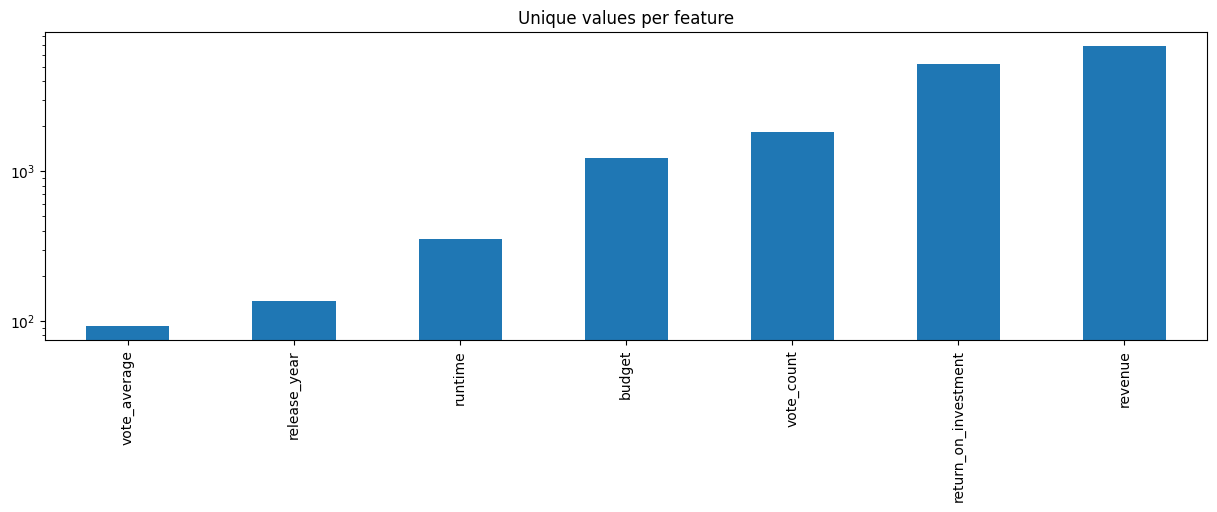

In [31]:
unique_numerical_values = movies_df.select_dtypes(include="number").nunique().sort_values()

unique_numerical_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

#### Missing Values

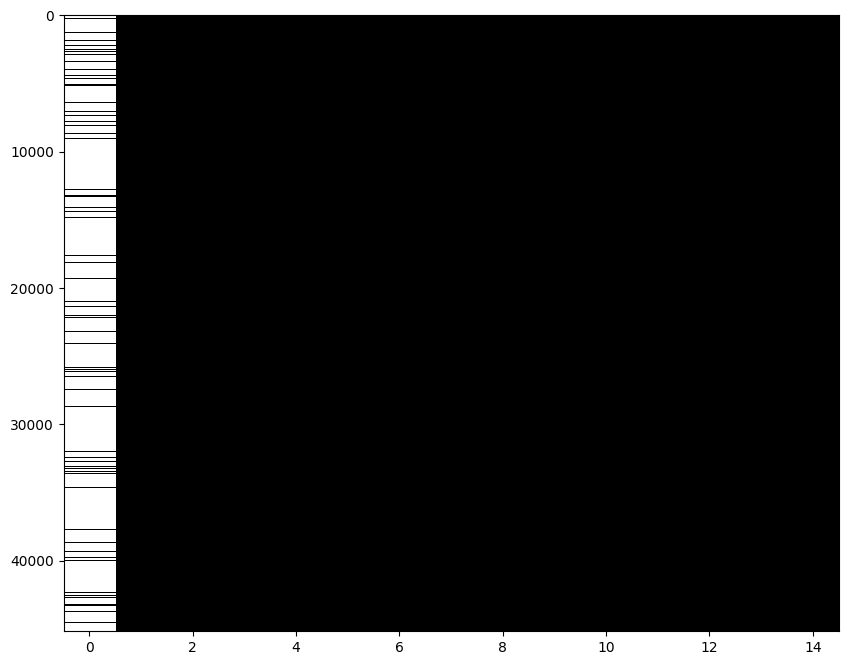

In [32]:
plt.figure(figsize=(10,8))
plt.imshow(movies_df.isna(), aspect="auto",
           interpolation="nearest", cmap="gray")


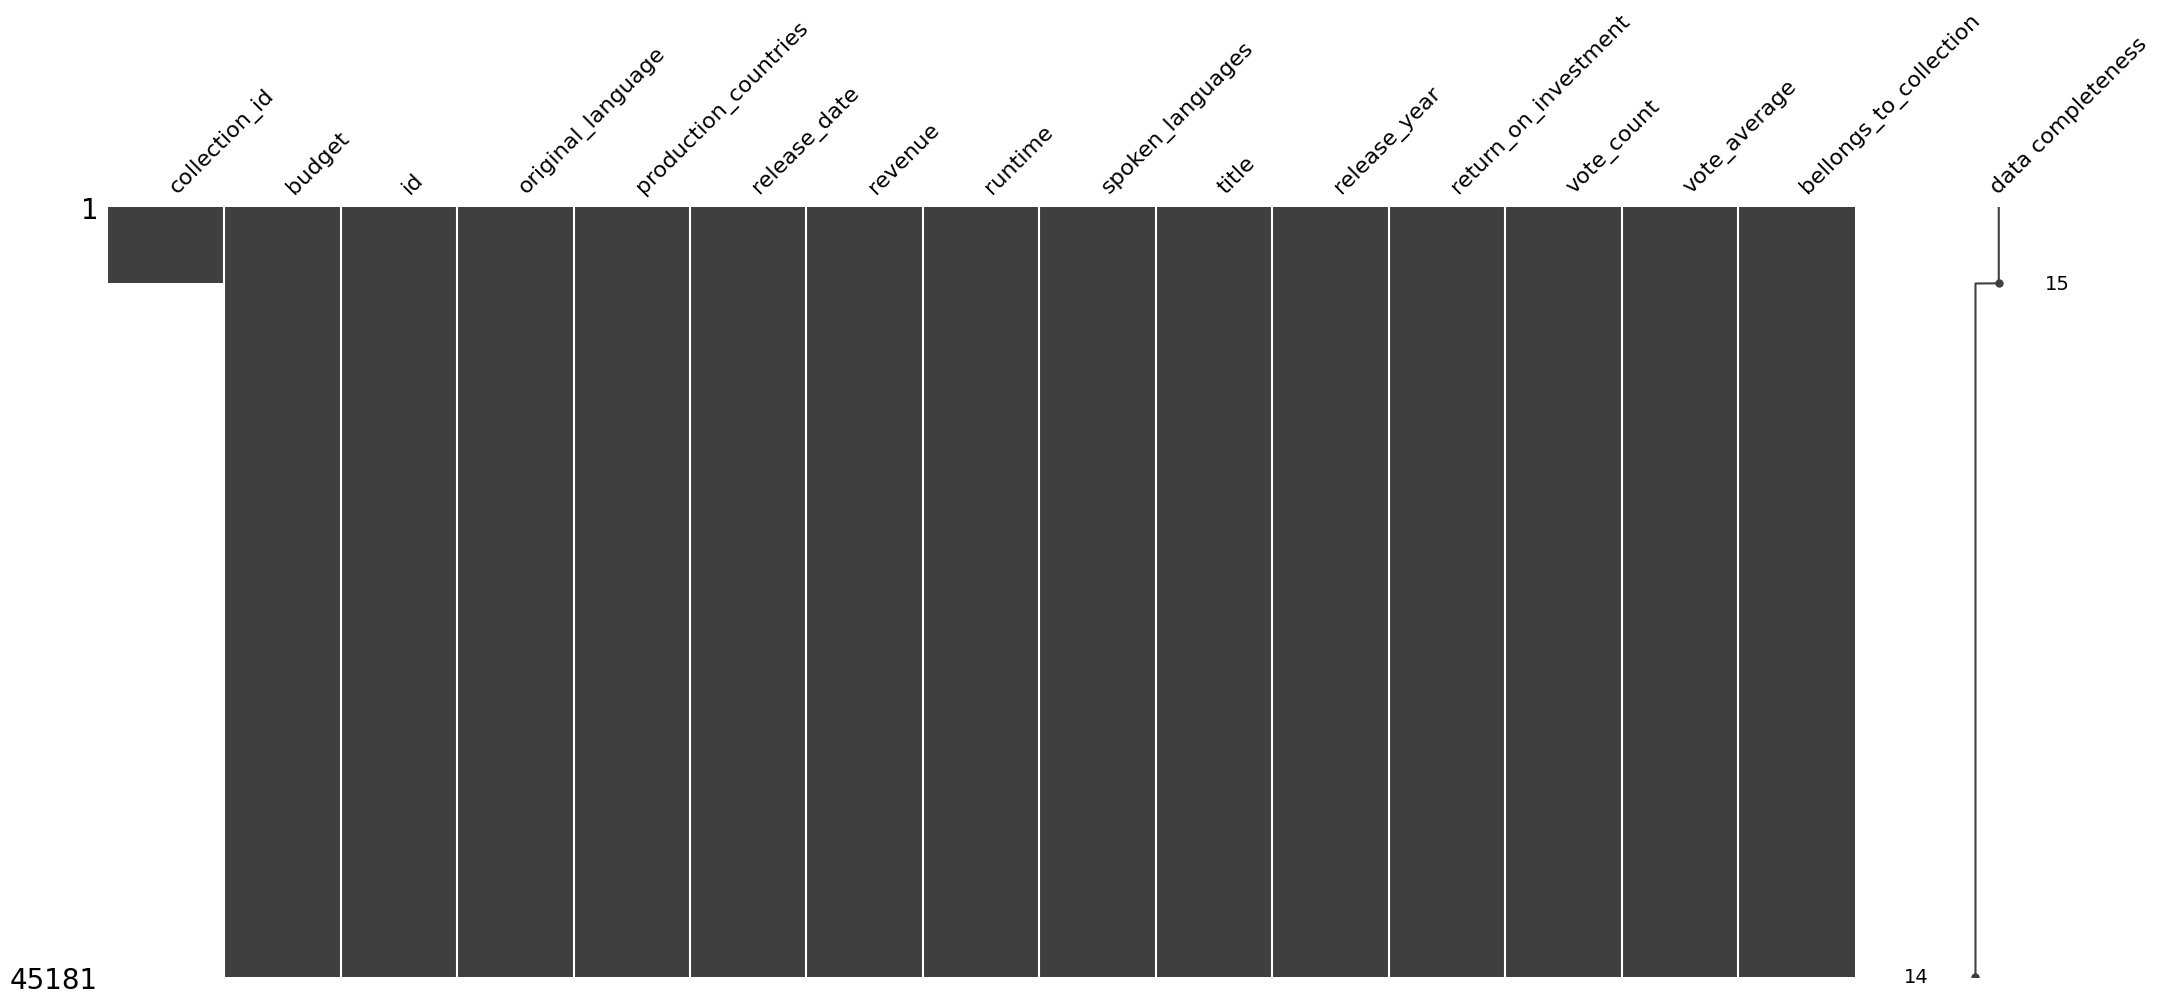

In [33]:
import missingno as msno
msno.matrix(movies_df, labels=True, sort="descending");

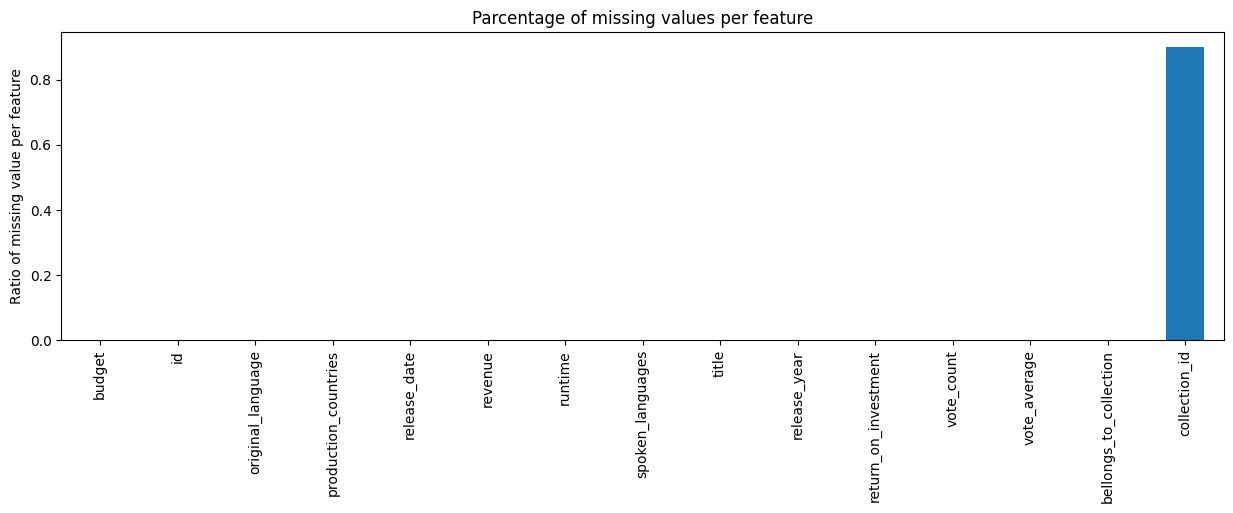

In [34]:
movies_df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15,4),
    title="Parcentage of missing values per feature",
    ylabel="Ratio of missing value per feature"
);

### Feature Distribution

This will give us an idea how values are distributed across each feature


The right next below figure shows the distrution of the all features that aren't numerical, meaning all categorical features

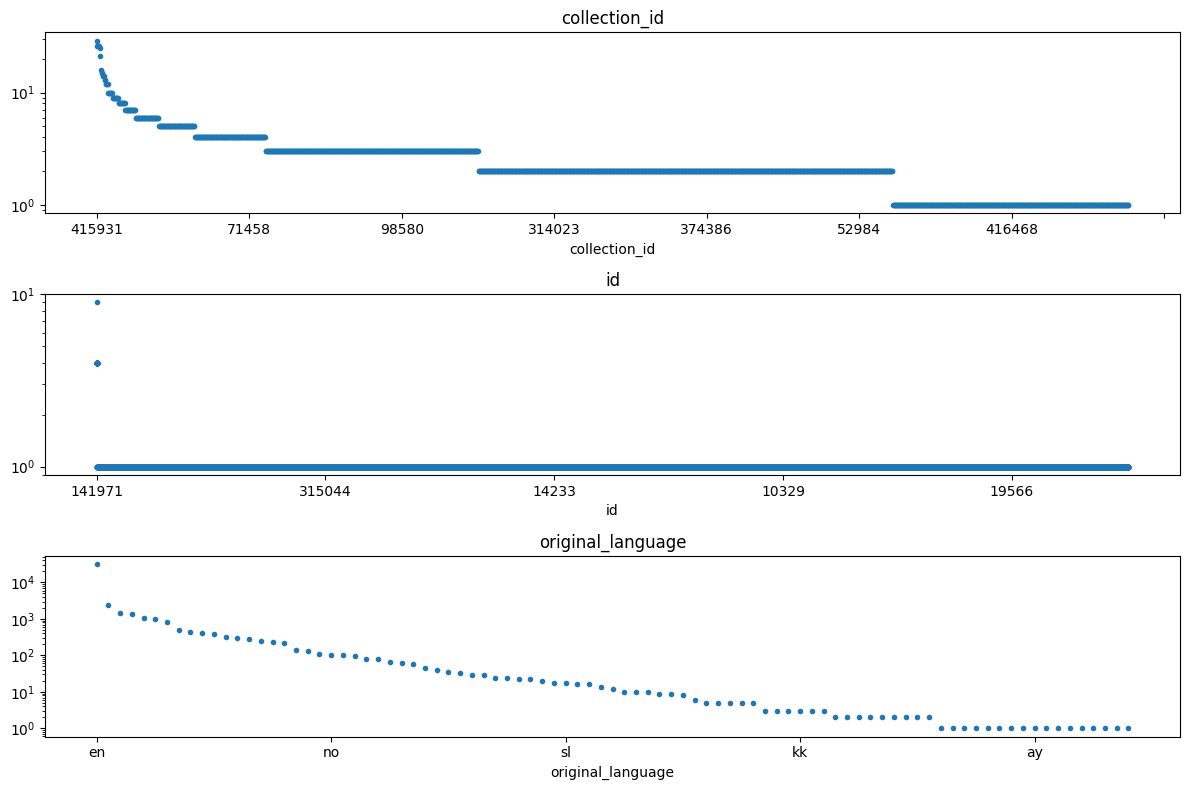

In [37]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12,8))
movies_non_numerical = movies_df.select_dtypes(exclude=["number","datetime"])

for col, ax in zip(movies_non_numerical, axes.ravel()):



    movies_non_numerical[col].value_counts().plot(

        logy=True, title=col, lw=0, marker=".", ax=ax
    )

plt.tight_layout();

### Numerical Features Distribution

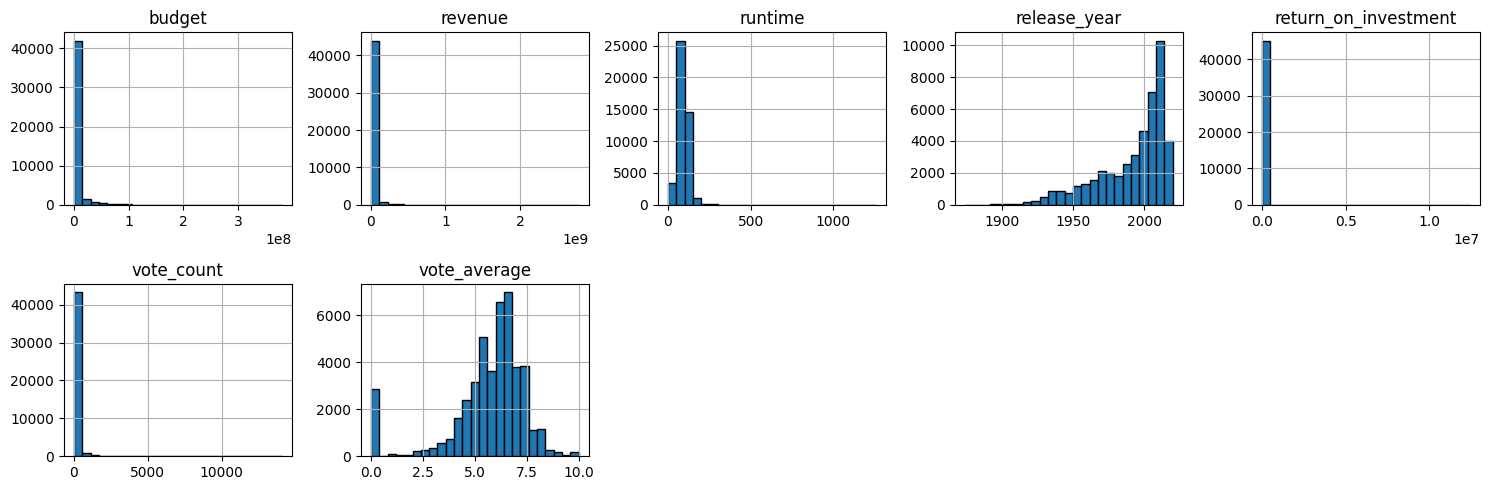

In [38]:
movies_df.hist(bins=25,
               figsize=(15, 5),
               layout=(-1, 5),
               edgecolor="black")
plt.tight_layout()

bellongs_to_collection    0.900688
return_on_investment      0.880658
revenue                   0.835750
budget                    0.803103
original_language         0.713419
dtype: float64

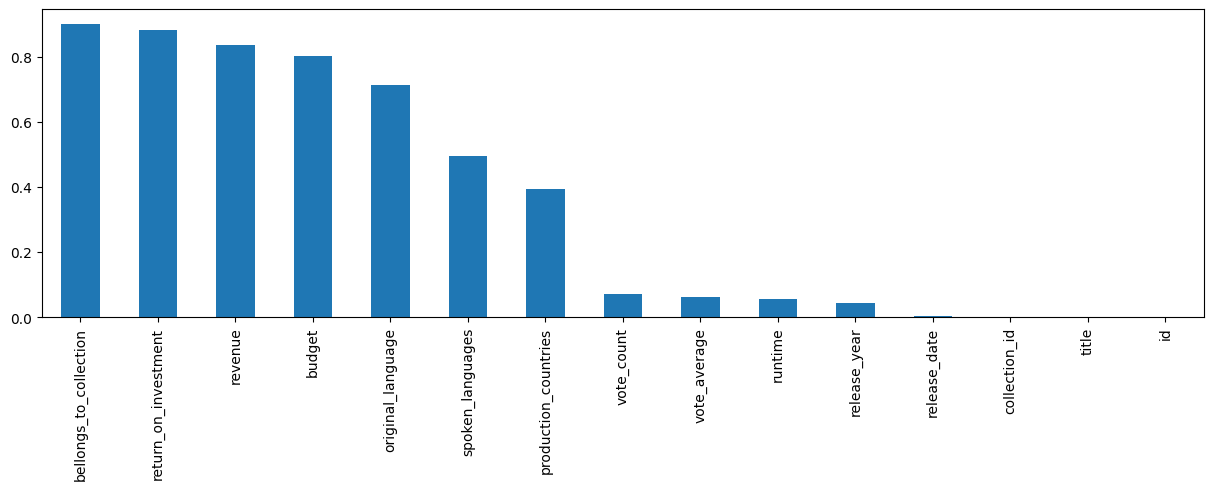

In [48]:
most_freq_entry = movies_df.mode()

df_freq = movies_df.eq(most_freq_entry.values, axis=1).mean().sort_values(ascending=False)

display(df_freq.head())

df_freq.plot.bar(figsize=(15,4));

### Visualizing Ooutliers or Undisirable Records

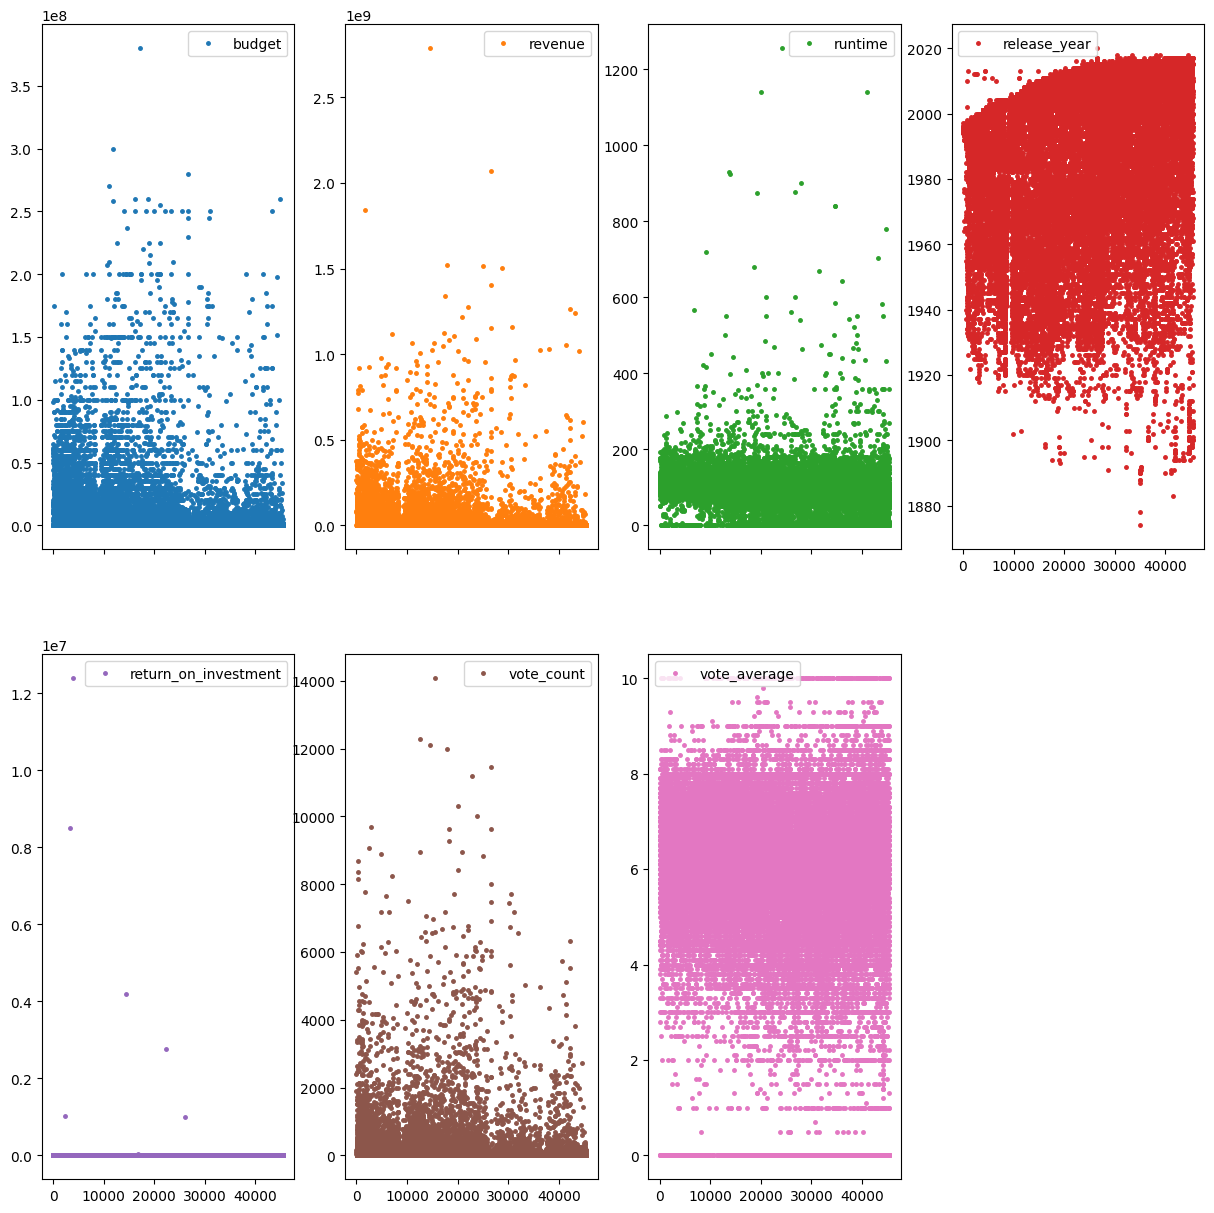

In [45]:
movies_df.plot(
    lw=0, marker=".", subplots=True,
    layout=(-1,4), markersize=5, figsize=(15,15)
);

It seems we have some points that stand out from the usual range. For example, which movie last above 1200 minutes? lets have a look at it

In [46]:
movies_df["runtime"].describe()

count    45181.000000
mean        94.199730
std         38.319487
min          0.000000
25%         85.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64

In [47]:
movies_df[movies_df["runtime"] > 1200] 

,collection_id,budget,id,original_language,production_countries,release_date,revenue,runtime,spoken_languages,title,release_year,return_on_investment,vote_count,vote_average,bellongs_to_collection
24196,NaN,0.0,67493,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",1978-10-01,0.0,1256.0,"[{'iso_639_1': 'Unknown', 'name': 'Unknown'}]",Centennial,1978,0.0,8.0,7.9,False


And certanly Centenial title is not a movie, it is a serie.

But in spite of this row -Centennial.. what kind of movie last more than 4 hours?

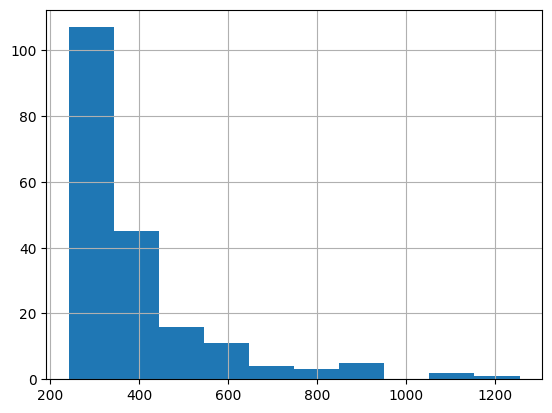

In [57]:
movies_df.loc[movies_df["runtime"] > 240, "runtime"].sort_values(ascending=False).hist();

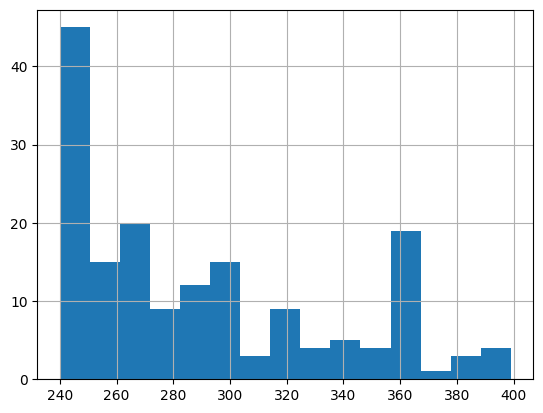

In [71]:
movies_df.loc[movies_df["runtime"].isin(range(240, 400)), "runtime"].hist(bins=15);

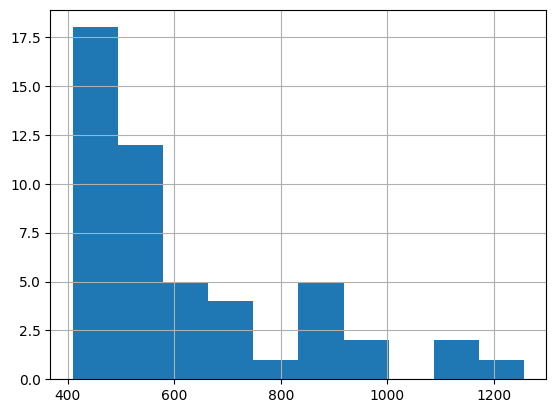

In [73]:
movies_df.loc[movies_df["runtime"] > 400, "runtime"].hist();

In [77]:
movies_df[movies_df["runtime"] > 1000]

,collection_id,budget,id,original_language,production_countries,release_date,revenue,runtime,spoken_languages,title,release_year,return_on_investment,vote_count,vote_average,bellongs_to_collection
19985,NaN,0.0,142051,en,"[{'iso_3166_1': 'Unknown', 'name': 'Unknown'}]",2001-01-09,0.0,1140.0,"[{'iso_639_1': 'Unknown', 'name': 'Unknown'}]",Jazz,2001,0.0,3.0,5.7,False
24196,NaN,0.0,67493,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",1978-10-01,0.0,1256.0,"[{'iso_639_1': 'Unknown', 'name': 'Unknown'}]",Centennial,1978,0.0,8.0,7.9,False
40932,NaN,0.0,126820,en,"[{'iso_3166_1': 'Unknown', 'name': 'Unknown'}]",1994-09-18,0.0,1140.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Baseball,1994,0.0,4.0,8.5,False


In [82]:
movies_df[movies_df["runtime"].isin(range(400, 1000))][["title", "release_year", "runtime"]]

,title,release_year,runtime
6753,Shoah,1985,566.0
8643,War and Peace,1966,422.0
9125,From the Earth to the Moon,1998,720.0
9215,The 10th Kingdom,2000,417.0
10042,Satantango,1994,450.0
12937,John Adams,2008,501.0
13066,Into the West,2005,552.0
13788,Berlin Alexanderplatz,1980,931.0
13974,Heimat: A Chronicle of Germany,1984,925.0
14495,Hitler: A Film from Germany,1977,442.0


Let's search a random title from this filtering and see if it is a movie.. for example the title [Empire](https://www.filmaffinity.com/es/film975551.html) and this is kind of intereting that, in fact, it is a movie... a movie of 485 minutes... a really low rated one by the way.. this could qualify as outliear because it is not a serie.

It is also shown titles such as "The Godfather Trilogy: 1972-1990"... is that supposed to be a movie? it seems to be a collection, but in that case, there is a field for collections already.


As you can see, spotting outliers is a draining task if you were to search for each record to figure out if it qqualifies as a an outlier... Luckly, there are numerical approach to get done this task.


One quick and straightforward option is the boxplot and it is a graph that shows an Interquartile Range (IQR) that in simple words, it divides the data into 4 intervals of the distribution of the standard deviation

<Axes: >

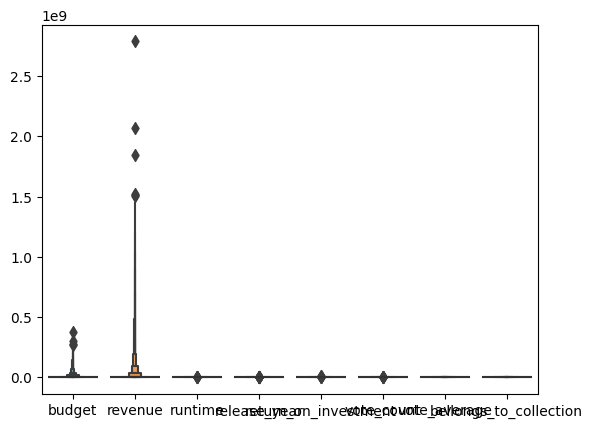

In [88]:
import seaborn as sns
sns.boxenplot(data=movies_df)

<Axes: >

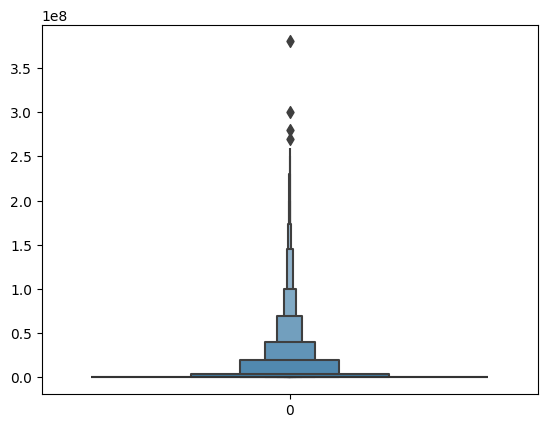

In [89]:
sns.boxenplot(data=movies_df["budget"])

<Axes: >

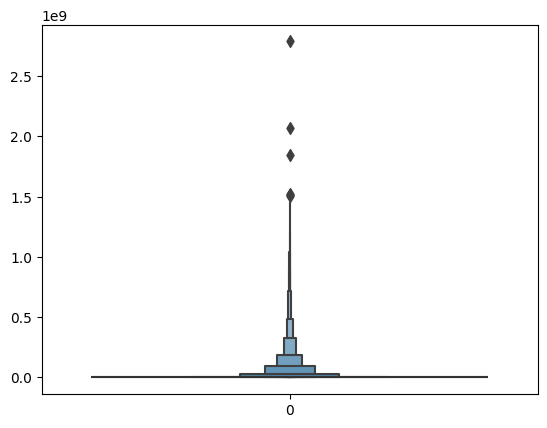

In [90]:
sns.boxenplot(data=movies_df["revenue"])

<Axes: >

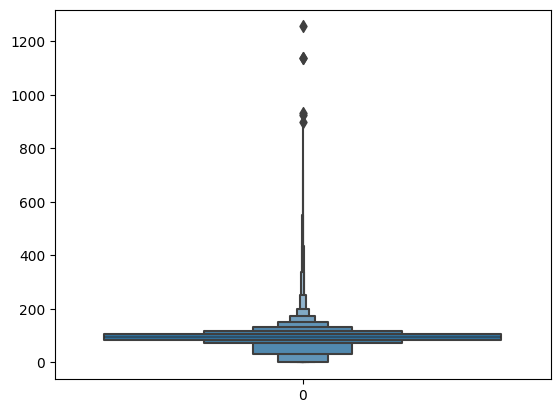

In [91]:
sns.boxenplot(data=movies_df["runtime"])

<Axes: >

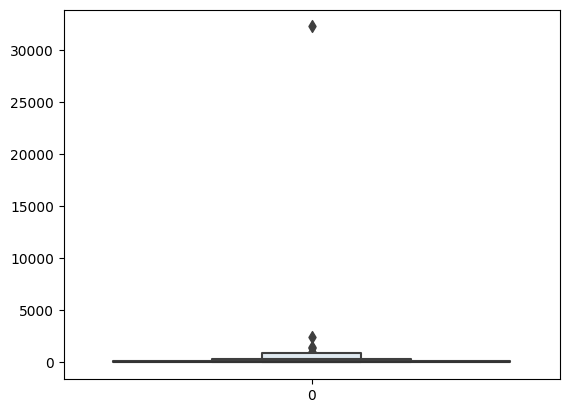

In [113]:
sns.boxenplot(data=movies_df["original_language"].value_counts())


In [146]:
from scipy.stats import norm

def plot_gauss_belt(data_1d):

    mean = np.mean(data_1d)
    std_dev = np.std(data_1d)


    Q1 = np.percentile(data_1d, 25)
    Q3 = np.percentile(data_1d, 75)

    x_values = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)

    gaussian = norm.pdf(x_values, mean, std_dev)

    plt.plot(x_values, gaussian, label= str(data_1d.name + " Distribution"))
    plt.axvline(mean, color='b', linestyle='--', label='mean')
    plt.axvline(Q1, color='r', linestyle='--', label='Q1')
    plt.axvline(Q3, color='g', linestyle='--', label='Q3')
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show();

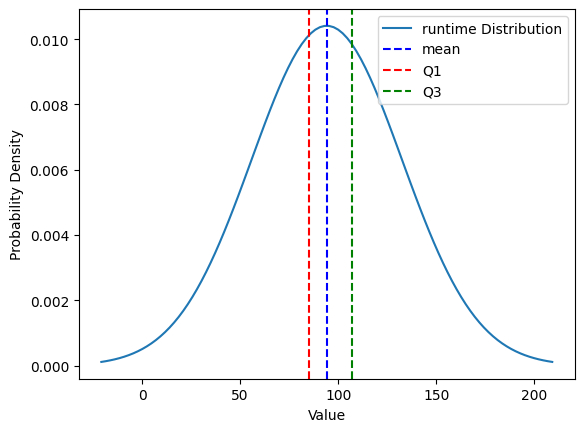

In [147]:
plot_gauss_belt(movies_df["runtime"])

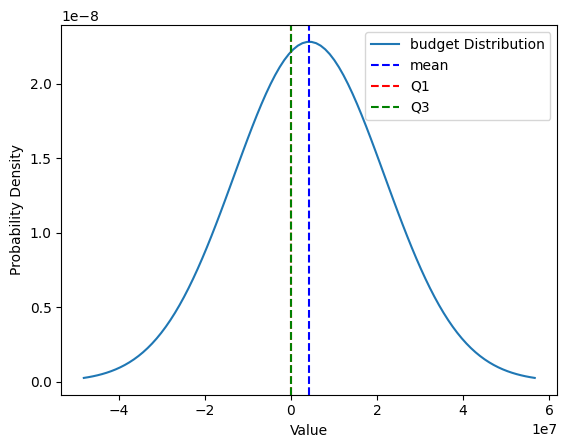

In [148]:
plot_gauss_belt(movies_df["budget"])

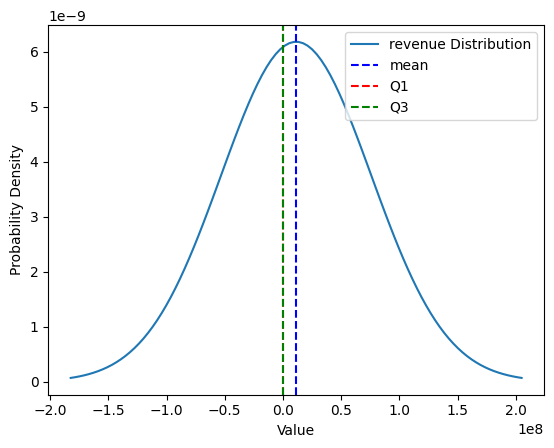

In [149]:
plot_gauss_belt(movies_df["revenue"])

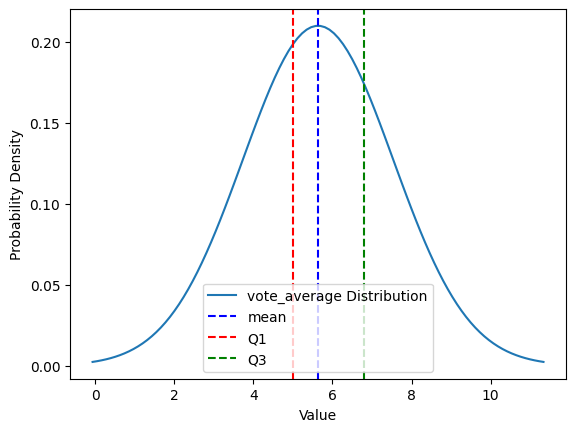

In [163]:
plot_gauss_belt(movies_df["vote_average"])

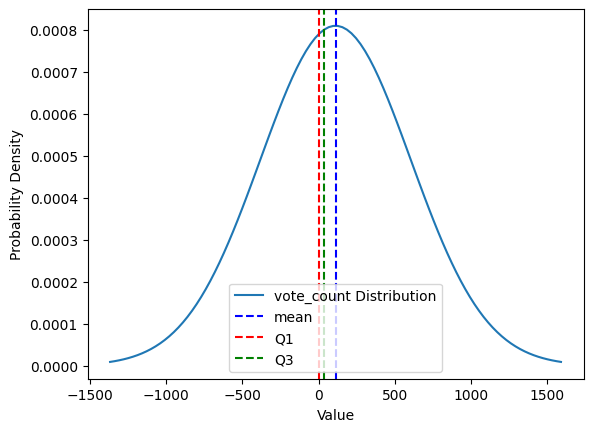

In [165]:
plot_gauss_belt(movies_df["vote_count"])

Certainly there are significally outliers such as budget and revenue where there is some movies really far away of the mean.. may be that unbalance points are explained by  the big capital resourses that hollywood industry has, at least a way more than any other independent movie. May be the data set contains a signicant quantity of independent movies and perhaps the best approach will be clustrization in order to create categories such as "is this an a independent production movie?" and maybe that will allow us to get rid of the usage of these features

In [139]:
movies_draft = movies_df.copy()

In [157]:
(movies_draft["budget"] == 0).sum() / movies_draft.shape[0] * 100

80.31030743011442

In [158]:
(movies_draft["revenue"] == 0).sum() / movies_draft.shape[0] * 100

83.57495407361502

In [161]:
movies_csv["revenue"].isna().sum()

6

In [162]:
(movies_csv["revenue"] == 0).sum() / movies_csv.shape[0] * 100

83.69330928605991